In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pdb

It's easiest to do with TI. Assume we have uncertainties at each point.  So we will have a standard deviation in dhdl at each of $k$ lambda points. 

In [2]:
nlam = 11  # initial number of lambda
ninit = 10000  # initial number of samples
lambdas = np.linspace(0,1,nlam) # initial lambdas
stdev = np.array([0.01,0.02,0.03,0.04,0.05,0.08,0.1,0.16,0.15,0.10,0.06])  # initial uncertainties after one run
nsamples = ninit*np.ones(nlam)

If we are missing some of the data, we can just spline without it, and if we are missing edges, we set them equal to the neighbors.  That is a very rough but reasonable guess to start with, we will get better soon. 

Approximate $\sigma^2n$ as a function of $\lambda$, and fit a spline.

In [3]:
fit_var = scipy.interpolate.CubicSpline(lambdas,nsamples*(stdev**2))

In [4]:
spacings = np.linspace(0,1,50*nlam)

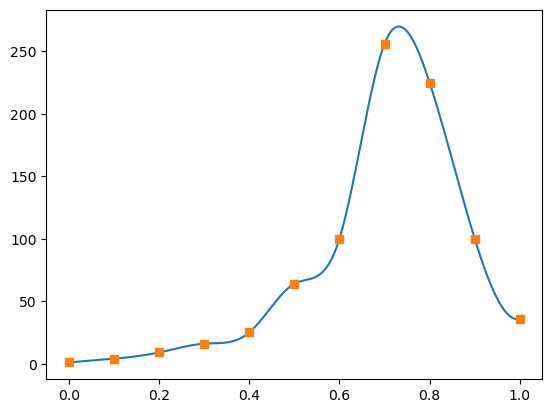

In [5]:
plt.plot(spacings,fit_var(spacings))
plt.plot(lambdas,nsamples*stdev**2,"s")
plt.show()

The total variance will be $\sum_i \frac{var(\lambda_i) w_{\lambda}^2}{n_i} $, so we want to decide the locations of the $n$ simulations that will minimize the total variance. 

Figuring out $w_{\lambda}$ is a little hard when we have uneven spacings, we'll just do it as the difference between consecutive lambdas, $\lambda_{i+1} - \lambda_i$, averaged at each $i$.

In [55]:
def expected_variance(nsamps,lambdas,varfunc,components=False):
    nonzero_locs = (nsamps!=0)
    dlambda = np.diff(lambdas[nonzero_locs])
    wlambda = np.zeros(len(dlambda)+1)
    wlambda[1:] += dlambda
    wlambda[:-1] += dlambda
    wlambda *= 0.5
    #print(wlambda,np.sum(wlambda))
    #print(varfunc(lambdas[nonzero_locs])*(wlambda/nsamps[nonzero_locs]))
    vals = varfunc(lambdas[nonzero_locs])*(wlambda**2/nsamps[nonzero_locs])
    vsum = np.sum(vals)
    if components==False:
        return vsum
    else:
        return vsum,vals

If we just had to run one simulation, this would be easy, as we find the location that minizes the variance.  But we need to iteratively find where to put them.

In [56]:
# initially we have ninit points at all locations.
ntotal = 101
lamall = np.linspace(0,1,ntotal)
nall = np.zeros([ntotal])
for i in range(ntotal):
    if (i%10 == 0):
        nall[i] = ninit

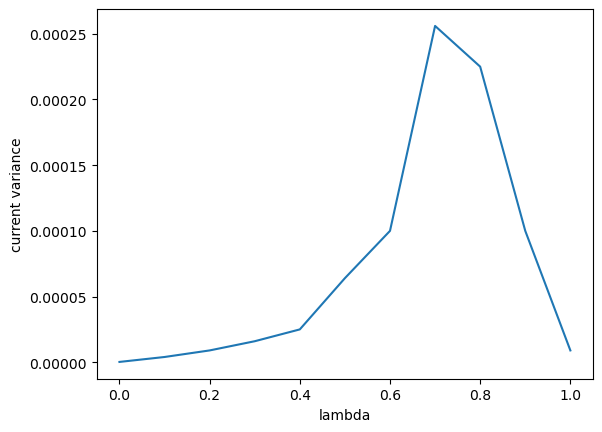

In [57]:
#contribution to the uncertainty at each point. This is what we want to see reduced.
total,vals = expected_variance(nsamps=nall,lambdas=lamall,varfunc=fit_var,components=True)
plt.plot(lamall[nall!=0],vals)
plt.ylabel('current variance')
plt.xlabel('lambda')
plt.show()

Now iteratively add points:

In [58]:
numruns = 10
runlocs = np.zeros(numruns)
runmins = np.zeros(numruns)
for i in range(numruns):
    expect_current = expected_variance(nsamps=nall,lambdas=lamall,varfunc=fit_var)
    min_i = 0
    min_trial = expect_current
    for j in range(ntotal):
        ntrial = nall.copy()
        ntrial[j] += ninit
        # if we add more samples here, how much does it improve the uncertainty
        expect_trial = expected_variance(nsamps=ntrial,lambdas=lamall, varfunc=fit_var)
        #print(i,j,expect_trial)
        if expect_trial < min_trial:   # OK, this currently the lowest point
            min_j = j
            min_trial = expect_trial
    # OK we have found the location the minimizes the next place. Change nall
    nall[min_j] += ninit
    runlocs[i] = min_j
    runmins[i] = min_trial

New locations data is to be added to

In [59]:
runlocs

array([74., 84., 65., 55., 77., 88., 68., 45., 73., 90.])

What the variance decreases to after each addition:

In [60]:
runmins

array([0.00066395, 0.00058426, 0.00051215, 0.00047039, 0.00043024,
       0.00039757, 0.00036697, 0.00034749, 0.00032905, 0.00031105])

Where the new data gets put:

In [61]:
nall

array([10000.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0., 10000.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0., 10000.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0., 10000.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
       10000.,     0.,     0.,     0.,     0., 10000.,     0.,     0.,
           0.,     0., 10000.,     0.,     0.,     0.,     0., 10000.,
           0.,     0.,     0.,     0., 10000.,     0.,     0.,     0.,
           0., 10000.,     0.,     0., 10000.,     0., 10000.,     0.,
           0., 10000., 10000.,     0.,     0., 10000.,     0.,     0.,
       10000.,     0.,     0.,     0., 10000.,     0.,     0.,     0.,
       10000.,     0., 20000.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0., 10000.])

New variance at all points after adding 10 points.

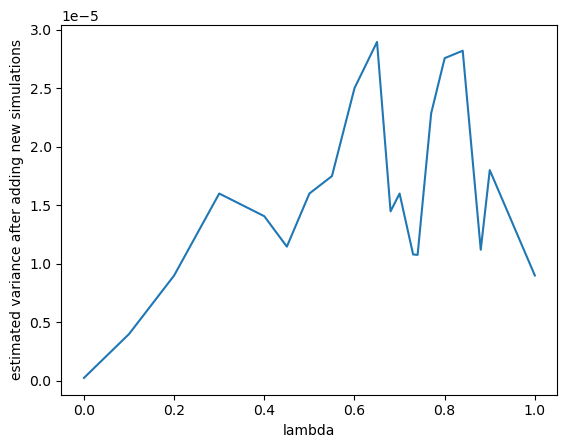

In [62]:
#contribution to the uncertainty at each point after adding data.
total,vals = expected_variance(nsamps=nall,lambdas=lamall,varfunc=fit_var,components=True)
plt.plot(lamall[nall!=0],vals)
plt.ylabel('estimated variance after adding new simulations')
plt.xlabel('lambda')
plt.show()